# TP 5 suite : Adaptation de domaine avec Kernel Mean Matching 



Soit le jeu de données simulées suivant :

In [1]:
import numpy as np 

x = 11*np.random.random(200)- 6.0
y = x**2 + 10*np.random.random(200) - 5
S = np.c_[x, y] # source

x = 2*np.random.random(10) - 6.0
y = x**2 + 10*np.random.random(10) - 5
T = np.c_[x, y] # cible

On représente sur un graphique le jeu de données : 




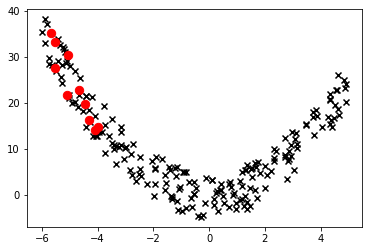

In [2]:
import matplotlib.pyplot as plt

plt.scatter(S[:,0], S[:,1], color='black', marker='x')
plt.scatter(T[:,0], T[:,1], color='red',s=70)
plt.show()

Le problème d'optimisation KMM empirique s'écrit comme suit :

 $\min_\omega  \frac{1}{n_s^2}\omega^\top K \omega - \frac{2}{n_s^2} \kappa^\top \omega + const	\ s.t. \ \omega_i\in[0,B] \text{ et } |\sum_{i=1}^{n_s} \omega_i - n_s| \leq n_s\epsilon$

 avec $K_{i,j}:=k(x_i^s,x_j^s)$, $\kappa_i := \frac{n_s}{n_t}\sum_{j=1}^{n_t}k(x_i^s,x_j^t)$, et $\epsilon = O(\frac{B}{\sqrt{n_s}})$.

 C'est un problème d'optimisation quadratique. Pour le résoudre, on utilise la bibliothèque `cvxopt` dédiée à l'optimisation convexe. Pour plus de détails, voir : https://cvxopt.org/ et https://cvxopt.org/userguide/coneprog.html#quadratic-cone-programs.



1. Ecrire une fonction `kmm` qui prend comme paramètre les données sources et cible et qui retourne le vecteur de ponderation $\omega$. On considère deux types de noyau : le noyau linéaire et le noyau rbf. La fonction prend aussi comme parmètres le type de noyau à utiliser, ainsi que les hyperparamètres $B$ et $\epsilon$. Vous pouvez utiliser la méthode pairwise_kernels de sk-learn pour calculer le noyau entre deux données : https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_kernels.html.


In [3]:
from cvxopt import matrix, solvers
from sklearn.metrics.pairwise import pairwise_kernels

def kernel_mean_matching(T, S, kern='lin', B=1.0, eps=None):
    nt = T.shape[0]
    ns = S.shape[0]
    if eps == None:
        eps = B/np.sqrt(ns)
    if kern == 'lin':
        K = np.dot(Z, Z.T)
        kappa = np.sum(np.dot(Z, X.T)*float(ns)/float(nt),axis=1)
    elif kern == 'rbf':
        K = pairwise_kernels(S,metric='rbf', gamma=1.0)
        kappa = np.sum(pairwise_kernels(S,T,metric='rbf', gamma=1.0),axis=1)*float(ns)/float(nt)
    else:
        raise ValueError('unknown kernel')
  
    K = matrix(K)
    kappa = matrix(kappa)
    G = matrix(np.r_[np.ones((1,ns)), -np.ones((1,ns)), np.eye(ns), -np.eye(ns)])
    h = matrix(np.r_[ns*(1+eps), ns*(eps-1), B*np.ones((ns,)), np.zeros((ns,))])
    
    sol = solvers.qp(K, -kappa, G, h)
    coef = np.array(sol['x'])
    return coef

2. Appliquer la fonction `kmm` au jeu données ci-dessus et représenter les données sur un graphique en tenant compte les pondérations apprises par la fonction `kmm`.

     pcost       dcost       gap    pres   dres
 0: -1.4432e+03 -2.7734e+05  3e+05  6e-17  2e-14
 1: -1.4772e+03 -1.0534e+04  9e+03  3e-16  4e-15
 2: -1.7013e+03 -2.5441e+03  8e+02  1e-16  3e-16
 3: -1.7971e+03 -1.9113e+03  1e+02  2e-16  2e-16
 4: -1.8176e+03 -1.8355e+03  2e+01  5e-16  1e-16
 5: -1.8217e+03 -1.8241e+03  2e+00  1e-16  1e-16
 6: -1.8224e+03 -1.8226e+03  2e-01  3e-16  1e-16
 7: -1.8225e+03 -1.8225e+03  2e-02  2e-16  1e-16
 8: -1.8225e+03 -1.8225e+03  3e-03  2e-16  1e-16
 9: -1.8225e+03 -1.8225e+03  5e-04  1e-16  1e-16
Optimal solution found.


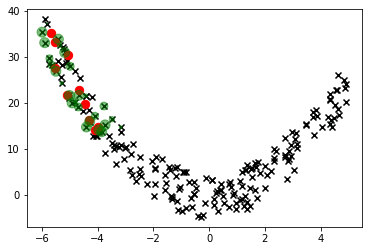

In [4]:

coef = kernel_mean_matching(T, S, kern='rbf', B=10)

plt.scatter(S[:,0], S[:,1], color='black', marker='x')
plt.scatter(T[:,0], T[:,1], color='red',s=70)
plt.scatter(S[:,0], S[:,1], color='green', s=coef*10, alpha=0.5)


3. Afficher la droite de régression apprise par la méthode de moindres carrées sur le jeu de données source.

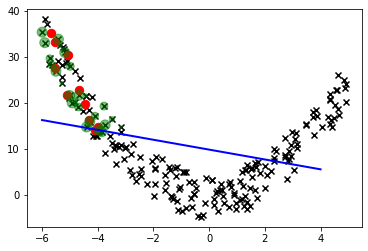

In [5]:
from sklearn.linear_model import LinearRegression

X=np.expand_dims(S[:,0],1)
y=S[:,1]

reg = LinearRegression().fit(X,y)
Xt = np.expand_dims(np.array([-6,4]),1)
yp = reg.predict(Xt)

plt.plot(Xt, yp, color='blue', linewidth=2)

plt.scatter(S[:,0], S[:,1], color='black', marker='x')
plt.scatter(T[:,0], T[:,1], color='red',s=70)
plt.scatter(S[:,0], S[:,1], color='green', s=coef*10, alpha=0.5)

4. Afficher la droite de régression apprise par la méthode de moindres carrées sur le jeu de données source en tenant en compte la pondération donnée par `kmm`. Pour cela, utiliser le paramère `sample_weight` de la méthode LinearRegression de sklearn : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

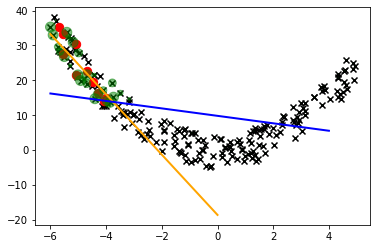

In [6]:
reg_kmm = LinearRegression().fit(X,y,np.squeeze(coef))
Xtp = np.expand_dims(np.array([-6,0]),1)
ypp = reg_kmm.predict(Xtp)

plt.plot(Xtp, ypp, color='orange', linewidth=2)

plt.plot(Xt, yp, color='blue', linewidth=2)
plt.scatter(S[:,0], S[:,1], color='black', marker='x')
plt.scatter(T[:,0], T[:,1], color='red',s=70)
plt.scatter(S[:,0], S[:,1], color='green', s=coef*10, alpha=0.5)

## Références




1.   Gretton, Arthur, et al. "Covariate shift by kernel mean matching." Dataset shift in machine learning 3.4 (2009):  http://www.gatsby.ucl.ac.uk/~gretton/papers/covariateShiftChapter.pdf

2.   Notebook inspiré de : https://github.com/vodp/py-kmm

